# <span style="color:blue;" >Image Classification on Tensorflow flowers dataset</span>



Workflow of the project:

1. Install tensorflow and keras
2. Collect the dataset
3. Examining and Understanding the Data
4. Build an input pipeline
5. Build the model
6. Train the model
7. Test the model
8. Improve the model and repeat the process
9. Test the results with your own sample image 

Furthermore, To implement a GUI for this project(optional)

10. Save the model in Hierarchical Data Format
11. Install Tkinter
12. Create a gui file that opens the files and then classifies the selected image


## <span style="color:orange;">Importing the libraries required</span>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## <span style="color:orange;">Downloading and exploring the dataset</span>

The url mentioned below uses tensorflow flower dataset that consists about 3,700 images of flowers.It contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_directory = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_directory = pathlib.Path(data_directory)

After the download is complete, you should  have a copy of the dataset available.

##### <span style="color:black;">Getting the exact count of number of images from the downloaded file</span>

In [3]:
image_count = len(list(data_directory.glob('*/*.jpg')))
print(image_count)

3670


##### <span style="color:black;">Opening few images from the dataset</span>

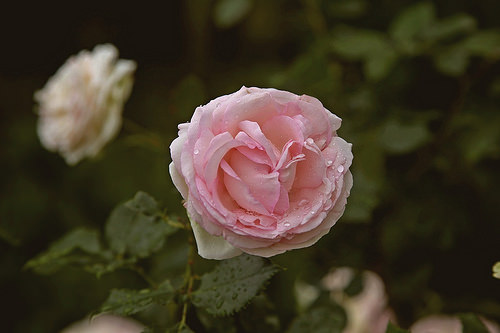

In [8]:
roses = list(data_directory.glob('roses/*'))
PIL.Image.open(str(roses[100]))

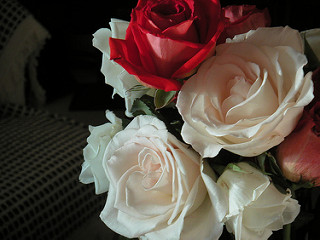

In [9]:
PIL.Image.open(str(roses[1]))

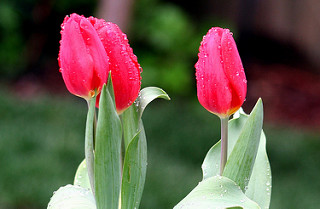

In [10]:
tulips = list(data_directory.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

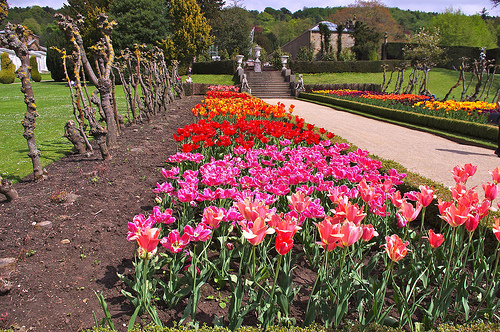

In [11]:
PIL.Image.open(str(tulips[9]))

## <span style="color:orange;">Load data using a Keras utility</span>

### Creating the dataset

Set the following parameters for the loader(can be customized):

In [12]:
batch_size = 32
img_height = 180
img_width = 180

When constructing your model, it's a good idea to employ a validation split. Let us utilise 75% of the photos for training and 25% for validation.

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2753 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_directory,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 917 files for validation.


The dataset class names may be found in the 'class names' field. These match to the directory names in alphabetical order.

In [15]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## <span style="color:orange;">Visualizing the data</span>


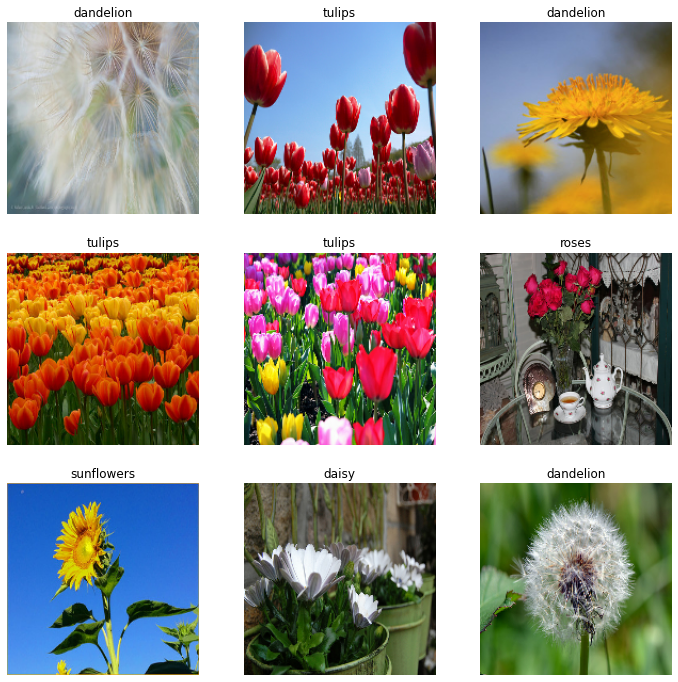

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

By supplying these datasets to 'Model.fit,' we will train the model. Also we may manually traverse over the dataset and get batches of photos if preferred

In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Configure the dataset for optimal performance.

Let's make sure we're using buffered prefetching so we can get data from disc without I/O becoming blocked. When loading data, you should utilise the following two methods:

- After the pictures are loaded from disc during the first epoch, 'Dataset.cache' retains them in memory. This will prevent the dataset from becoming a bottleneck during the training of your model. You may also use this approach to establish a performant on-disk cache if your dataset is too huge to fit in memory.
- During training, 'Dataset.prefetch' combines data preparation and model execution.



In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## <span style="color:orange;">Standardize the data</span>

In [27]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## <span style="color:orange;">Creating the model</span>

In [29]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## <span style="color:orange;">Compiling the model</span>

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## <span style="color:orange;">Printing the model summary using .summary() method</span>

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## <span style="color:orange;">Training the model</span>

10 epochs

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
87/87 [==============================] - 18s 204ms/step - loss: 1.2686 - accuracy: 0.4620 - val_loss: 1.2907 - val_accuracy: 0.4406
Epoch 2/10
87/87 [==============================] - 18s 212ms/step - loss: 0.9834 - accuracy: 0.6131 - val_loss: 0.9984 - val_accuracy: 0.5965
Epoch 3/10
87/87 [==============================] - 18s 211ms/step - loss: 0.7889 - accuracy: 0.7105 - val_loss: 0.9946 - val_accuracy: 0.6041
Epoch 4/10
87/87 [==============================] - 18s 208ms/step - loss: 0.5886 - accuracy: 0.7831 - val_loss: 0.9622 - val_accuracy: 0.6543
Epoch 5/10
87/87 [==============================] - 18s 206ms/step - loss: 0.3776 - accuracy: 0.8656 - val_loss: 1.0323 - val_accuracy: 0.6565
Epoch 6/10
87/87 [==============================] - 18s 209ms/step - loss: 0.2484 - accuracy: 0.9175 - val_loss: 1.3268 - val_accuracy: 0.5998
Epoch 7/10
87/87 [==============================] - 18s 206ms/step - loss: 0.1313 - accuracy: 0.9568 - val_loss: 1.4130 - val_accuracy: 0.6369

### Improving the training model using data augumentation 

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Few enhanced instances by applying data augmentation to the same image many times

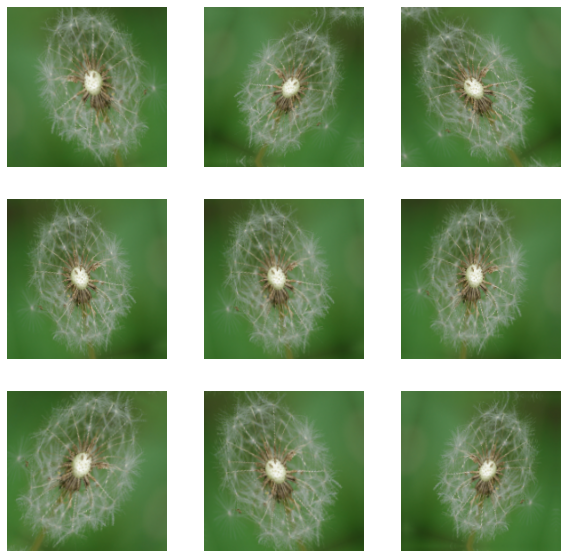

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Applying Dropout to the layer

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## <span style="color:orange;">Compiling and training the model again</span>

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Getting the model summary

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
87/87 [==============================] - 21s 236ms/step - loss: 1.3576 - accuracy: 0.3974 - val_loss: 1.1745 - val_accuracy: 0.4973
Epoch 2/15
87/87 [==============================] - 20s 229ms/step - loss: 1.1085 - accuracy: 0.5387 - val_loss: 1.0720 - val_accuracy: 0.5780
Epoch 3/15
87/87 [==============================] - 20s 231ms/step - loss: 1.0020 - accuracy: 0.5993 - val_loss: 0.9796 - val_accuracy: 0.5987
Epoch 4/15
87/87 [==============================] - 20s 235ms/step - loss: 0.9192 - accuracy: 0.6487 - val_loss: 0.9004 - val_accuracy: 0.6401
Epoch 5/15
87/87 [==============================] - 20s 234ms/step - loss: 0.8651 - accuracy: 0.6684 - val_loss: 0.9391 - val_accuracy: 0.6434
Epoch 6/15
87/87 [==============================] - 20s 231ms/step - loss: 0.7999 - accuracy: 0.6974 - val_loss: 0.8244 - val_accuracy: 0.6816
Epoch 7/15
87/87 [==============================] - 20s 231ms/step - loss: 0.7572 - accuracy: 0.7123 - val_loss: 0.7553 - val_accuracy: 0.6979

## <span style="color:orange;">Classify the picture of flower of your own choice </span>

Now let us apply our model to the test by classifying a picture that wasn't in the training or validation sets.

Paste the image url of your choice in 'sample_image_url'

In [41]:
sample_image_url = "https://static01.nyt.com/images/2021/02/21/realestate/17garden1/17garden1-mediumSquareAt3X-v2.jpg"
sample_image_path = tf.keras.utils.get_file('Sample_Image', origin=sample_image_url)

img = tf.keras.utils.load_img(
    sample_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

581632/571710 [==============================] - 0s 0us/step
This image most likely belongs to roses with a 97.05 percent confidence.


## <span style="color:orange;">Save the model </span>

In [42]:
model.save("model1_flowers.h5")

Now if you want to create a gui for this model, save the model and then using Tkinter launch a GUI to open the any image related to above model and classify it according by creating a gui file